In [56]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid

%matplotlib inline
sns.set()

In [57]:
class Discriminator(nn.Module):
    def __init__(self, channels, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input: N x channels x 64 x 64
            nn.Conv2d(
                in_channels=channels,
                out_channels=features_d,
                kernel_size=4,
                stride=2,
                padding=1,
            ), # 32x32
            nn.LeakyReLU(negative_slope=2e-1, inplace=True),
            self._block(in_channels=features_d, out_channels=features_d*2, kernel_size=4, stride=2, padding=1), # 16x16
            self._block(in_channels=features_d*2, out_channels=features_d*4, kernel_size=4, stride=2, padding=1), # 8x8
            self._block(in_channels=features_d*4, out_channels=features_d*8, kernel_size=4, stride=2, padding=1), # 4x4
            nn.Conv2d(
                in_channels=features_d*8,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=0,
            ), #1x1
            nn.Sigmoid(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.LeakyReLU(negative_slope=2e-1, inplace=True),
        )
            
    def forward(self, x):
        return self.disc(x)

In [58]:
class Generator(nn.Module):
    def __init__(self, latent_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x latent_dim x 1 x 1
            self._block(in_channels=latent_dim, out_channels=features_g*16, kernel_size=4, stride=1, padding=0), # N x f_g*16 x 4 x 4
            self._block(in_channels=features_g*16, out_channels=features_g*8, kernel_size=4, stride=2, padding=1), # 8x8
            self._block(in_channels=features_g*8, out_channels=features_g*4, kernel_size=4, stride=2, padding=1), # 16x16
            self._block(in_channels=features_g*4, out_channels=features_g*2, kernel_size=4, stride=2, padding=1), # 32x32
            nn.ConvTranspose2d(
                in_channels=features_g*2,
                out_channels=channels_img,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
        )
            
    def forward(self, x):
        return self.gen(x)

In [59]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [60]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 32
LEARNING_RATE = 2e-4
LATENT_DIM = 100
CHANNELS = 1
FEATURES_DISC = 64
FEATURES_GEN = 64
IMG_SIZE = 64
BATCH_SIZE = 128
MOMENTUM1 = 9e-1 # first momentum for adam optimizer, beta1
MOMENTUM2 = 1 - 1e-3 # second momentum for adam optimizer, beta2

In [61]:
transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), transforms.Normalize([5e-1 for _ in range(CHANNELS)], [5e-1 for _ in range(CHANNELS)], inplace=True)]
)

In [62]:
# MNIST
dataset = datasets.MNIST(root='./dataset', download=True, train=True, transform=transform)
CHANNELS = 1

In [63]:
# CelebA
# dataset = datasets.CelebA(root='./dataset', download=True, train=True, transform=transform)
# CHANNELS = 3

In [64]:
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), drop_last=True, shuffle=True, pin_memory=True)

In [65]:
fixed_noise = torch.randn((32, LATENT_DIM, 1, 1)).to(DEVICE)

disc = Discriminator(channels=CHANNELS, features_d=FEATURES_DISC).to(DEVICE)
gen = Generator(latent_dim=LATENT_DIM, channels_img=CHANNELS, features_g=FEATURES_GEN).to(DEVICE)

init_weights(disc)
init_weights(gen)

optim_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(MOMENTUM1, MOMENTUM2))
optim_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(MOMENTUM1, MOMENTUM2))

criterion = nn.BCELoss()

# training mode
disc.train()
gen.train() 

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpla

In [66]:
fake_imgs = []
for epoch in range(1, EPOCHS + 1):
    for batch_idx, (real_img, _) in enumerate(loader):
        real_img = real_img.to(DEVICE)
        
        noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(DEVICE)
        fake_img = gen(noise)

        disc_real = disc(real_img).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake_img.detach()).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        lossD = (lossD_real + lossD_fake) / 2
        
        disc.zero_grad()
        lossD.backward()
        
        optim_disc.step()
        
        output = disc(fake_img).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        optim_gen.step()
        
        if batch_idx == len(loader) - 1:
            print(f'Epoch: [{epoch}/{EPOCHS}] | LossD: {lossD:.4f} | LossG: {lossG:.4f}')
            with torch.inference_mode():
                fake_img = gen(fixed_noise)
                
                img_grid_fake = make_grid(fake_img[:32], normalize=True)

                fake_imgs.append(img_grid_fake)

Epoch: [1/32] | LossD: 0.5085 | LossG: 1.2756
Epoch: [2/32] | LossD: 0.5852 | LossG: 1.2616
Epoch: [3/32] | LossD: 0.5169 | LossG: 1.2004
Epoch: [4/32] | LossD: 0.3473 | LossG: 0.4852
Epoch: [5/32] | LossD: 0.2719 | LossG: 2.8921
Epoch: [6/32] | LossD: 0.1809 | LossG: 1.7394
Epoch: [7/32] | LossD: 0.3140 | LossG: 1.9623
Epoch: [8/32] | LossD: 0.2132 | LossG: 2.7879
Epoch: [9/32] | LossD: 0.2436 | LossG: 4.2528
Epoch: [10/32] | LossD: 0.0841 | LossG: 3.4084
Epoch: [11/32] | LossD: 0.0741 | LossG: 3.6129
Epoch: [12/32] | LossD: 0.2354 | LossG: 2.4717
Epoch: [13/32] | LossD: 0.1994 | LossG: 2.2172
Epoch: [14/32] | LossD: 0.0704 | LossG: 3.2818
Epoch: [15/32] | LossD: 0.0273 | LossG: 4.6251
Epoch: [16/32] | LossD: 0.0574 | LossG: 4.7503
Epoch: [17/32] | LossD: 0.1650 | LossG: 4.2854


KeyboardInterrupt: 

(-0.5, 529.5, 265.5, -0.5)

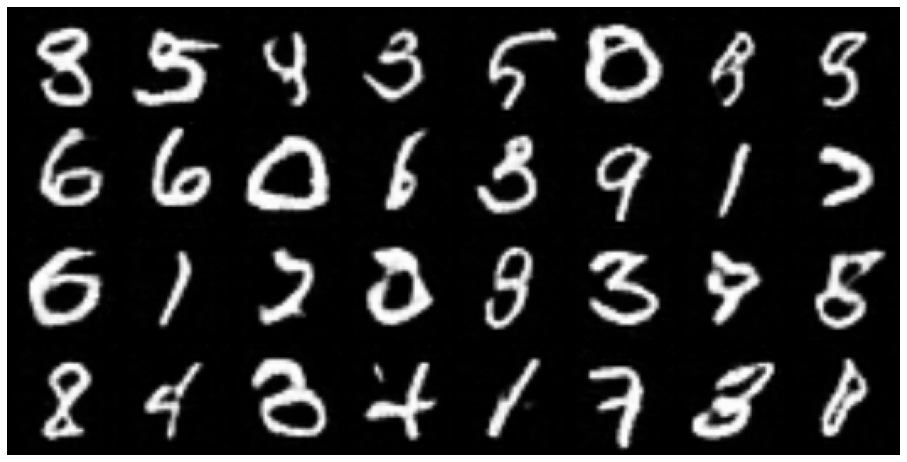

In [77]:
plt.figure(figsize=(16, 16))
plt.imshow(fake_imgs[-1].cpu().numpy().transpose((1, 2, 0)))
plt.axis('off')